In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
from operator import attrgetter
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(10,5)})
os.getcwd()
os.chdir('C:\\Users\\tomdx\\justeat')

In [2]:
# Loading Data
cities = pd.read_csv('cities.csv')
country_currency_mapping = pd.read_csv('country_currency_mapping.csv',header=None)
currency_details = pd.read_csv('currency_details.csv')
dim_channel = pd.read_csv('dim_channel.csv')
fx_rates_eur = pd.read_csv('fx_rates_eur.csv')
platforms = pd.read_csv('platforms.csv')
transaction_dimensions = pd.read_csv('transaction_dimensions.csv')
transaction_financials = pd.read_csv('transaction_financials.csv')
user_engagements = pd.read_csv('user_engagements.csv')
interactions = pd.read_csv('CT8_raw_interactions.csv')

# Pre-processing

In [3]:
 # converting integer amounts in the transactions table into cash amounts.
currency_details = currency_details[['currency','exponent']] 
transaction_financials = pd.merge(transaction_financials,currency_details,how='inner',on='currency').drop_duplicates()
transaction_financials['exponent_val'] = transaction_financials['exponent'].apply(lambda x: 10**int(x))

In [4]:
transaction_dimensions = pd.merge(transaction_dimensions,currency_details,how='inner',on='currency').drop_duplicates()
transaction_dimensions['exponent_val'] = transaction_dimensions['exponent'].apply(lambda x: 10**int(x))
transaction_dimensions['value'] = transaction_dimensions['value'] /  transaction_financials['exponent_val']

In [5]:
transaction_dimensions = transaction_dimensions.rename(columns = {'customercityid':'city_id'})

In [6]:
# Converting all transaction values to EURO
fx_rates_eur = fx_rates_eur.rename(columns={'ccy':'currency'})
transaction_financials = pd.merge(transaction_financials,fx_rates_eur[['rate','currency']]).drop_duplicates()
for cost in transaction_financials.columns[2:7]:
    transaction_financials[cost] = transaction_financials[cost] /  transaction_financials['exponent_val']
    transaction_financials[cost] = transaction_financials[cost] *  transaction_financials['rate']
transaction_financials['currency'] = 'EUR'
transaction_financials = transaction_financials.drop(columns=['rate'])

In [7]:
transaction_dimensions = transaction_dimensions.rename(columns={'platform':' platform_id'})
transaction_dimensions = pd.merge(transaction_dimensions,platforms,on=' platform_id',how='inner')
transaction_dimensions = pd.merge(transaction_dimensions,dim_channel,on='channel_id',how='inner')

In [8]:
transaction_dimensions = pd.merge(transaction_dimensions,transaction_financials,on='transaction_id',how='inner')

#### 1. Which channel has the lowest cost per order on the WEB platform and what is this CPO?

In [9]:
transaction_dimensions = transaction_dimensions.drop_duplicates(['transaction_id'])
transaction_dimensions['total_cost'] = transaction_dimensions['marketing_cost'] + transaction_dimensions['operation_cost'] + \
                                    transaction_dimensions['administration_cost']

web_transactions = transaction_dimensions[transaction_dimensions['platform']=='WEB']

#### Method 1 


In [10]:
cpo = web_transactions.groupby(['channel_name'])['total_cost'].mean().reset_index().sort_values('total_cost')
cpo['total_cost'] = cpo['total_cost'].apply(lambda x : round(x,2))
cpo = cpo.rename(columns={'total_cost':'CPO'})
print('Least CPO = ', cpo.iloc[0]['CPO'])

Least CPO =  0.41


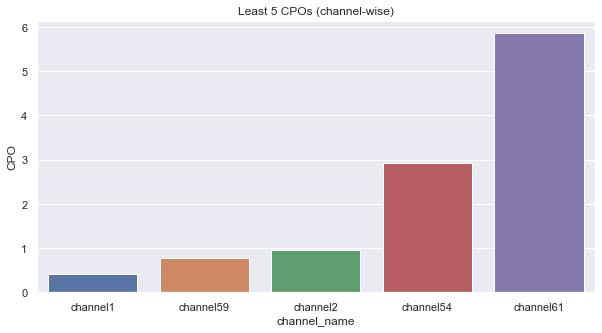

In [11]:
sns.barplot(y='CPO',x='channel_name',data=cpo.iloc[:5])
plt.title('Least 5 CPOs (channel-wise)')
plt.show()

#### Method 2


In [12]:
channel_id_orders = web_transactions.groupby(['channel_id'])['transaction_id'].count().reset_index().rename(columns= {'transaction_id':'#orders'})
channel_id_orders = pd.merge(channel_id_orders,dim_channel,on='channel_id',how='inner')
cpo1 = web_transactions.groupby(['channel_name'])['total_cost'].sum().reset_index()
cpo1 = pd.merge(cpo1,channel_id_orders,on='channel_name',how='inner')
cpo1['CPO'] = round(cpo1['total_cost']/cpo1['#orders'],2)
cpo1 = cpo1.sort_values('CPO')
cpo1.head()

,channel_name,total_cost,channel_id,#orders,CPO
0,channel1,56486.072605,1,136270,0.41
8,channel59,2759.551962,12,3607,0.77
4,channel2,8555.670325,7,8951,0.96
7,channel54,331534.223155,2,113687,2.92
9,channel61,13426.894630,11,2296,5.85


#### 2. Which countries are a prospective profit pool of Kaboom and how do you suggest marketing budget distribution should happen there?


In [13]:
transaction_dimensions['total_revenue'] = transaction_dimensions['commission_revenue'] + \
                                            transaction_dimensions['other_revenue'] 

transaction_dimensions['profit'] = transaction_dimensions['total_revenue'] - transaction_dimensions['total_cost'] 

In [14]:
transaction_dimensions.groupby('country')['profit'].sum().reset_index()

,country,profit
0,AT,-170858.270000
1,CH,-334927.001474
2,NL,240058.600000
3,PL,-111491.611676


In [15]:
# Cost Distribution 
cos_di = transaction_dimensions.groupby('country').agg({'marketing_cost':sum,'administration_cost':sum,'operation_cost':sum})
round((cos_di.T/cos_di.T.sum())*100,2)

country,AT,CH,NL,PL
marketing_cost,33.31,33.29,33.30,33.30
administration_cost,33.30,33.35,33.39,33.27
operation_cost,33.39,33.35,33.31,33.42


In [16]:
# Revenue Distribution 
rev_di = transaction_dimensions.groupby('country').agg({'commission_revenue':sum,'other_revenue':sum})
round((rev_di.T/rev_di.T.sum())*100,2)

country,AT,CH,NL,PL
commission_revenue,50.03,49.96,50.01,50.03
other_revenue,49.97,50.04,49.99,49.97


In [17]:
order_count = user_engagements.groupby('customerid')['transaction_id'].count().reset_index().rename(columns={'transaction_id':'number_of_orders'})
unique_customers  = pd.DataFrame(user_engagements['customerid'].unique()).rename(columns={0:'customerid'})

In [18]:
user_engagements['date'] = user_engagements['sessiondatetime'].apply(lambda x : str(x).split(' ')[0])
user_engagements['month_year'] = user_engagements['date'].apply(lambda x: '-'.join(str(x).split('-')[:2]))
user_engagements = user_engagements.dropna(subset=['sessiondatetime']) 

In [19]:
user_transactions = pd.merge(transaction_dimensions,user_engagements,on='transaction_id',how='inner').drop_duplicates() 

In [20]:
metrics = user_transactions[['month_year','country','marketing_cost','operation_cost','administration_cost',\
    'commission_revenue','other_revenue','total_revenue','total_cost','profit','customerid_y','value','channel_name']] 

In [21]:
channel_profit = metrics.groupby(['channel_name','country','month_year']).agg({'total_cost':sum,'total_revenue':sum}).reset_index()

channel_profit['marketing_profit%'] = (channel_profit['total_revenue'] - channel_profit['total_cost'])/channel_profit['total_cost']

 #### 3. What can be the primary KPIs for Kaboom which the performance marketing team should follow? Please show a dashboard which tracks 3 primary KPIs  over time

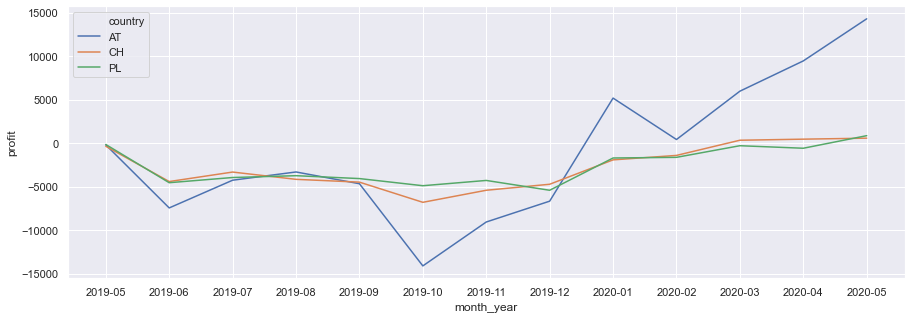

In [22]:
sns.set(rc={'figure.figsize':(15,5)})
dd = metrics.groupby(['month_year','country']).agg({'profit':sum,'total_revenue':sum}).reset_index()
dd['profit%']  = round((dd['profit'] / dd['total_revenue'])*100,2)
dd = dd[dd['country']!='NL']
sns.lineplot(x='month_year',y='profit',hue='country',data = dd)
plt.show()

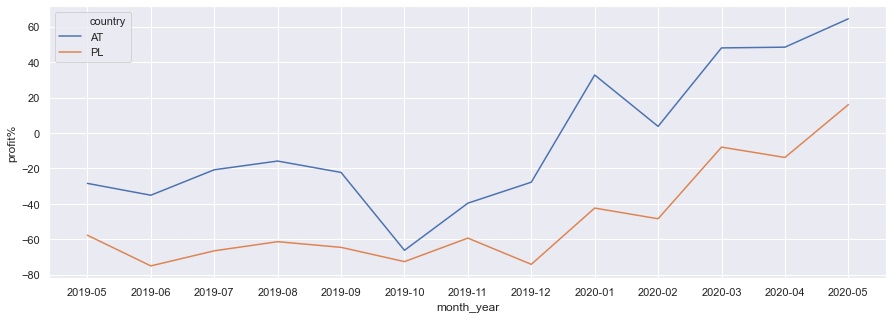

In [23]:
sns.lineplot(x='month_year',y='profit%',hue='country',data = dd[dd['country']!='CH'])
plt.show()

In [24]:
cac = metrics.groupby(['month_year']).agg({'marketing_cost':sum,'customerid_y':'count','value':sum,'value':sum}).reset_index()
cac['CAC'] = round(cac['marketing_cost']/cac['customerid_y'],2)

In [25]:
user_transactions['customerid_y'].count()

751165

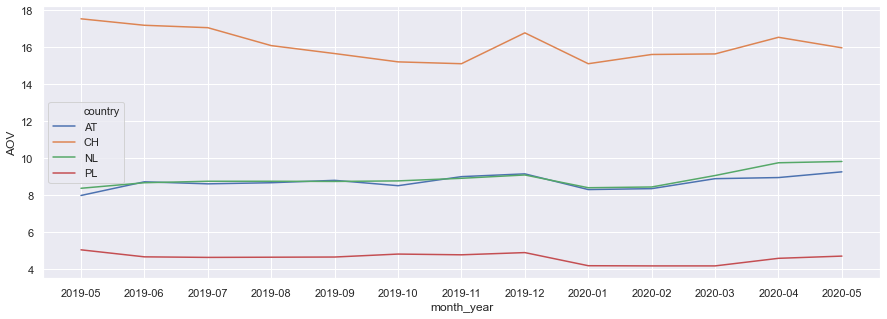

In [26]:
# Average Order Value

aov = user_transactions.groupby('transaction_id')['customerid_y'].count().reset_index().rename(columns={'customerid_y':'num_orders'})
aov = pd.merge(transaction_dimensions[['country','orderdatetime','value','total_revenue','transaction_id']],aov[['transaction_id','num_orders']],on='transaction_id')

aov['date'] = aov['orderdatetime'].apply(lambda x : str(x).split(' ')[0])
aov['month_year'] = aov['date'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

aov = aov.groupby(['month_year','country']).agg({'num_orders':sum,'value':sum}).reset_index()
aov['AOV'] = round(aov['value']/aov['num_orders'],2)
sns.lineplot(x='month_year',y='AOV',hue='country',data = aov)
plt.show()

In [27]:
# Cohort Analysis 

In [28]:
df = user_engagements.copy()
n_orders = df.groupby(['customerid'])['transaction_id'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['customerid'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

df = df.sort_values('date')
df['date'] = pd.to_datetime(df['date'])

df['order_month'] = df['date'].dt.to_period('M')
df['cohort'] = df.groupby('customerid')['date'] \
                 .transform('min') \
                 .dt.to_period('M')

df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customerid', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

 
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

13.51% of customers ordered more than once.


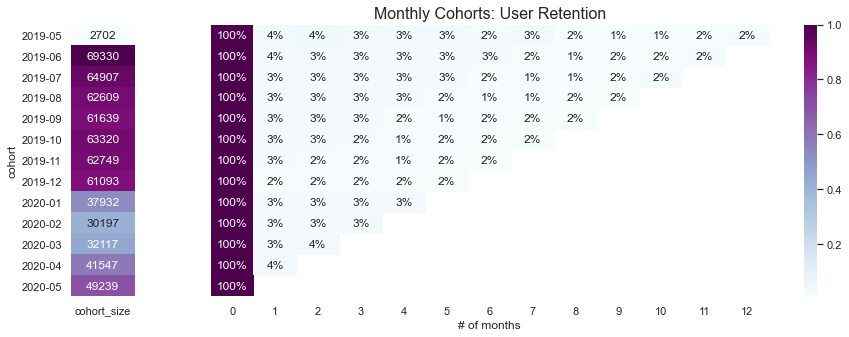

In [29]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='BuPu', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of months',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap='BuPu', 
                ax=ax[0])

 

#### 4. For channel 1 and for channel 2 which city has the most orders?


In [30]:
df = pd.merge(transaction_dimensions,cities,on='city_id',how='inner').drop_duplicates(subset=['transaction_id']) 
df = df.loc[(df['channel_name'] =='channel1') | (df['channel_name'] =='channel2')]
grouped = df.groupby(['name','channel_name'])['transaction_id'].count().reset_index().rename(columns={'transaction_id':'count'})
grouped = grouped.sort_values('count',ascending=False)


In [31]:
grouped.head(1)

,name,channel_name,count
4712,cityNL89,channel1,31969


In [32]:
 grouped[grouped['channel_name']=='channel2'].head(1)

,name,channel_name,count
32,cityAT108,channel2,823


#### 5 Looking at the data, what time of the day do you see maximum installs happening for Kaboom?


In [33]:
interactions['interaction_type'] = interactions['interaction_type'].str.lower()
installed = interactions[interactions['interaction_type']=='install']

In [34]:
installed['interaction_hour'] = installed['interaction_timestamp'].apply(lambda x: x.split(' ')[1].split(':')[0])

In [35]:
df = installed['interaction_hour'].value_counts().reset_index().rename(columns={'index':'hour','interaction_hour':'installs'}) 

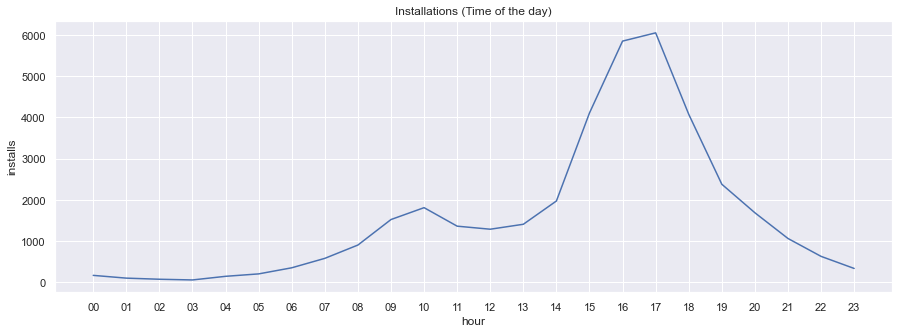

In [36]:
sns.lineplot(x='hour',y='installs',data=df)
plt.title('Installations (Time of the day)')
plt.show()